# CMA *Sampling*

In [22]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as ss
import math
import random
from collections import namedtuple
#%precision 4
#%matplotlib inline

In [23]:
# project python modules
from MH_Sampling import acceptance_decision
from FileHandling import save_state
from TestSuite import generate_state_space, generate_iid_samples, get_samples

# CMA Sampler

Both the CMA-ES optimization and sampling algorithm have a number of 
**strategy parameters** that do not change during the execution of the algorithm. 
We are using the default values as recommended in the paper *C. Igel, T. Suttorp, and N. Hansen, A Computational Efficient Covariance Matrix Update and a $(1+1)$-CMA for Evolution  Strategies*. henceforth called *the paper*.

In the update of the **global scale** $\sigma$, the following parameters with given initial values are used

- **damping parameter** $$k = 1 + \frac{d}{2}$$ where $d$ is the dimension of the state space. (**Note**: In the paper, $d$ is used for
the damping parameter instead of $k$ and $n$ for dimension instead of $d$)
- **target success rate** $$p_{s}^{succ} = \frac{2}{11}$$
(**Remark BM**: compare $p_{s}^{succ}$ to the optimal acceptance ratio in Metropolis-Hastings.)
- **learning rate** $$\lambda_p = \frac{1}{12}$$ used in the update of the average success rate 
$\bar{p}_s \in \left[ 0, 1 \right]$, cf. the procedure *update_scale* below for more information.

For the **covariance matrix adaptation**, they are

- **evolution point weight** $$\lambda_{\mathbf{p}} = \frac{2}{d+2}$$ 
- **covariance matrix weight** $$\lambda_{\mathbf{C}} = \frac{2}{d^2 + 6}$$
- **threshold** $$\theta_p$$ for *average success rate* $\bar{p}_s$. The update of the evolution point $\mathbf{p}_c$ and the covariance matrix $\mathbf{C}$ depend on the test $\bar{p}_s < \theta_p$, cf. the procedure *update_cov* below for more information.  

**Note**: in the CMA ES literature, step size is used instead of global scale. In order to be consistent 
with the MCMC literature we prefer and use the latter.

# Initial values 

The initial values are set as follows

- **average success rate** $\bar{p}_s = p_{s}^{succ}$ where $p_{s}^{succ}$ is the *target success rate*.
- **evolution point** $\mathbf{p}_c = \mathbf{0}$
- **covariance matrix** $\mathbf{C} = \mathbb{1}_d$

The choice of the initial candidate $\mathbf{x}_0$ and the initial global scale $\sigma$ are problem dependent.
Here, we initialize $\mathbf{x}_0$ with a random point in a hypercube centered in the origin. Its side can
vary. And $\sigma = 1$.

In [24]:
# save covariance matrix adaptation (CMA) parameters in Named Tuple

CMA_Parameters = namedtuple('CMA_Parameters', 
                               ['z_samples',
                               #Parameters used in the global scale control
                                's', 'k', 't_succ', 'c_p', 
                                #Parameters used in the covariance adaptation
                                'c_c', 'c_cov', 'p_thres'])

def init_CMA_pars(sp):
    dim = sp['dim']
    return CMA_Parameters(z_samples=get_samples(sp=sp, name='Z'),
                          s=1, 
                          k=1+dim/2, 
                          t_succ=2/11, 
                          c_p=1/12, 
                          c_c=2/(dim+2), 
                          c_cov=2/(dim**2+6), 
                          p_thres=0.44)

# Generation of the candidate $\mathbf{x}^{*}$

Let $\mathbf{C} = 
\mathbf{Q}\mathbf{Q}^{\top}$ be the Cholesky decomposition of the covariance matrix $\mathbf{C}$. The candidate next state $\mathbf{x}^{*}$ is generated as 

$$\mathbf{x}^{*} = \mathbf{x}_n + \sigma_n \mathbf{Q}_n \mathbf{z}_n$$

where $\sigma_n$ are the global scale, $\mathbf{Q}_n$ the Cholesky factor of $\mathbf{C}_n$,
and $\mathbf{z}_n \sim N(\mathbf{0}, \mathbb{1}_d)$ at time step $n$, respectively. 

In [25]:
def generate_CMA_candidate(current, scale, cov, z_sample):
    # Use postive definite square root of C, cf. Tutiorial, p. 6.
    Q = la.cholesky(cov) 
    y = Q @ z_sample
    candidate = current + scale*y
    return (candidate, y)

## Update of the global scale $\sigma$

**Each time step**, the global scale $\sigma$ is updated and the update consists of two steps. 
First, average success rate $\bar{p}_{s}$
is updated and this depends on the acceptance of the generated candidate. Next,
$\sigma$ itself is updated.

The **average success rate** $\bar{p}_{s}$ and the **global scale** 
$\sigma$ are updated as

\begin{align}
\bar{p}_{s} & \leftarrow (1 -  c_p) \bar{p}_{s} + c_p \textit{ accepted_p}\\
\sigma & \leftarrow  \sigma ~ exp \left( \frac{1}{k} \left( \bar{p}_{s} - \frac{p_{s}^{target}}{1 - p_{s}^{target}} (1-  \bar{p}_{s}) \right) \right)
\end{align}

In [26]:
def update_scale(p_succ, sigma, accepted_p, pars):
    # Parameters used in the global scale control
    k, t_succ, c_p = pars.k, pars.t_succ, pars.c_p
    
    # Update the average success rate.
    p_succ = (1- c_p)*p_succ + c_p*accepted_p

    # Update global scale.
    w = t_succ/(1-t_succ)
    sigma = sigma * np.exp(1/k*(p_succ - w*(1-p_succ)))
    return p_succ, sigma

In [27]:
def f(d):
    k=1+d/2
    t_succ = 2/11
    w = t_succ/(1-t_succ)
    return lambda x: np.exp(1/k*(x - w*(1-x)))

In [28]:
f_d = f(d=50)
f_d(2/11)

1.0000

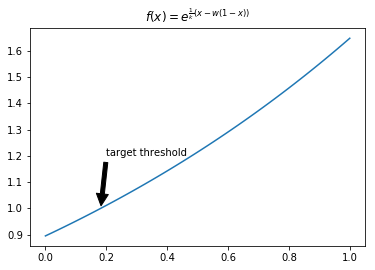

In [29]:
D = 2
k = 1 + D/2
f_d = f(d=D)
x_range = np.linspace(start=0, stop=1, num=50, endpoint=True)
f_range = f_d(x_range)
t_succ = 2/11
coords = (t_succ, f_d(t_succ))
plt.title(r'$f(x) = e^{\frac{1}{k} ( x - w (1 -  x ))}$')
plt.annotate('target threshold', xy=coords, xytext=(0.2, 1.2),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot(x_range, f_range);

# Update of the covariance matrix $\mathbf{C}$

The covariance matrix is updated only **when** the generated candidate $\mathbf{x}^{*}$ 
is **accepted**.
This update also consists of two steps. 
First, the evolution point $\mathbf{p}_{c}$
is updated followed by the update of the covariance matrix itself. 
These updates depend on whether $\bar{p}_s < \theta_p$ or not.

The **evolution point** $\mathbf{p}_{c}$ and the **covariance matrix** 
$\mathbf{C}$ are updated as

\begin{align}
\mathbf{p}_{c}  &\leftarrow
\begin{cases}
\left(1-\lambda_\mathbf{p} \right) \mathbf{p}_{c} + \sqrt{ \lambda_\mathbf{p}(2 - \lambda_\mathbf{p})}  
~\mathbf{y}   & \mbox{if $\bar{p_{s}} <  \theta_p$}\\
\left (1-\lambda_\mathbf{p} \right) \mathbf{p}_{c} & \mbox{otherwise}
\end{cases} \\
\mathbf{C} &\leftarrow	 
\begin{cases}
\left( 1- \lambda_\mathbf{C} \right) \mathbf{C} + \lambda_\mathbf{C}  
\mathbf{p}_{c}\mathbf{p}_{c}^{\top} & \mbox{if $\bar{p_{s}} < \theta_p$}\\
\left ( 1-\lambda_\mathbf{C} \right) \mathbf{C} + \lambda_\mathbf{C}   \left (\mathbf{p}_{c}\mathbf{p}_{c}^{\top} + \lambda_\mathbf{p}(2-\lambda_\mathbf{p}) \mathbf{C}  \right) & \mbox{otherwise}
\end{cases} 
\end{align}

where $\mathbf{y} = \mathbf{Q} \mathbf{z}$ with $\mathbf{z} \sim N(\mathbf{0}, \mathbb{1}_d)$ and $\mathbf{C} = 
\mathbf{Q}\mathbf{Q}^{\top}$, cf. above for more information about how samples are generated.

In [30]:
def update_cov(cov, evol_point, y, avg_success_rate, pars):
    # Parameters used in the covariance matrix adapation
    c_c, c_cov, p_thres = pars.c_c, pars.c_cov, pars.p_thres
    if avg_success_rate < p_thres:
        evol_point = (1-c_c)*evol_point + np.sqrt(c_c*(2-c_c))*y
        cov = (1-c_cov)*cov + c_cov*np.outer(evol_point.T, evol_point)
    else:
        evol_point = (1-c_c)*evol_point
        cov = (1-c_cov)*cov + c_cov*(np.outer(evol_point.T, evol_point) + c_c*(2-c_c)*cov)
    return evol_point, cov

# (1+1)-CMA ES Sampler

The sampler operates as follows

 Initialize $\mathbf{x}$, $\sigma = 1$, $\mathbf{C} = \mathbb{1}_d$, 
$\bar{p}_s = p_s^{target}$, and $\mathbf{p}_c = \mathbf{0}$

 **repeat** 
>   1. determine $\mathbf{Q}$ such that $\mathbf{C} = \mathbf{Q} \mathbf{Q}^\top$
>   2. $\mathbf{z} \sim N(\mathbf{0}, ~ \mathbb{1}_d)$
>   3. $\mathbf{x}^{*} = \mathbf{x} + \sigma ~ \mathbf{Q} ~ \mathbf{z}$
>   4. *accepted_p* = *acceptance_decision*($\mathbf{x}, \mathbf{x}^{*}, \pi$) where $\pi$ is the target distribution
>   5. **if** *accepted_p* **then** 
>>    * $\mathbf{x} \leftarrow \mathbf{x}^{*}$
>>    * *updateCov*($\mathbf{C}, ~ \mathbf{Q} \mathbf{z}, ~ \bar{p}_s, ~ \mathbf{p}_c$)

 **until** stopping criterium is met

In [31]:
def CMA_sampler(pars, target, initial_state, run_data):
    target_pdf, sp = target['pdf'], target['State Space']
    Origin, Id = sp['Origin'], sp['Id']
    s, p_succ, p_c = pars.s, pars.t_succ, Origin
    ds, N = run_data.DataStore, run_data.N
    z_samples = pars.z_samples
    
    x_current = initial_state
    C = Id
    
    save_state(data_store=ds, 
               step=0, 
               state=x_current, 
               value=target_pdf(x_current), 
               accepted_p=True, 
               mean=p_c, 
               covariance=C, 
               scale=s, 
               threshold=p_succ)
    
    for n in range(1, N):
        # generate new candidate sample
        x_new, delta = generate_CMA_candidate(current=x_current, scale=s, cov=C, z_sample=z_samples[n])
        
        # run Metropolis Hastings acceptance criteria
        accepted_p = acceptance_decision(current=x_current, proposed=x_new, pdf=target_pdf)
        p_succ, s = update_scale(p_succ=p_succ, sigma=s, accepted_p=accepted_p, pars=pars)
        
        if accepted_p:
            # accepted candidate becomes new state
            x_current = x_new
            p_c, C = update_cov(evol_point=p_c, cov=C, y=delta, avg_success_rate=p_succ, pars=pars)
        
        # save accepted and non-accepted sates in namedtuple
        save_state(data_store=ds, 
                   step=n, 
                   state=x_current, 
                   value=target_pdf(x_current), 
                   accepted_p=accepted_p, 
                   mean=p_c, 
                   covariance=C, 
                   scale=s, 
                   threshold=p_succ)
    return run_data